# Python для DataScience
## Курсовая работа

В этой курсовой работе мы будем обучать модель, предсказывающую цены на квартиры

In [1]:
from urllib import request
from os.path import isfile

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.manifold import TSNE
from xgboost import XGBRegressor
import pickle

from multiprocessing import Pool

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Загрузка данных

Скачаем датасеты:

In [2]:
train_url = 'https://uploads.hb.cldmail.ru/asset/1381522/attachment/302b3d11658ce764f4e8655292566e11.csv'
test_url = 'https://uploads.hb.cldmail.ru/asset/1381521/attachment/f74867a92dc85932950369d8d31db3b0.csv'

train_path = 'train.csv'
test_path = 'test.csv'

if not isfile(train_path):
    request.urlretrieve(train_url, train_path)
if not isfile(test_path):
    request.urlretrieve(test_url, test_path)

In [3]:
data = pd.read_csv(train_path)

### Очистка данных
Давайте проанализируем датасет

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [5]:
data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Давайте разберем датасет по пунктам

#### Оценим признак `Rooms`

In [9]:
data['Rooms'].describe()

count    10000.000000
mean         1.890500
std          0.839512
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         19.000000
Name: Rooms, dtype: float64

In [10]:
data['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Заменим выбросы ( rooms == 0 ) и ( rooms > 5 ) на среднее значение по выборке

In [11]:
rooms_mean = data.Rooms.mean()
data[data.Rooms > 5] = rooms_mean
data[data.Rooms < 1] = rooms_mean

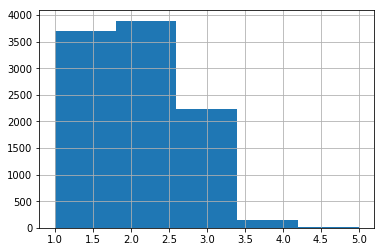

In [12]:
data.Rooms.hist(bins=5)

#### Оценим признак `LifeSquare`
Найдем те записи, где `LifeSquare` > `Square`

In [13]:
data[data.LifeSquare > data.Square].shape[0]

482

Выходит, что для 4% записей жилая площадь больше общей площади, что некорректно. Давайте оценим зависимость площадей.

(10, 250)

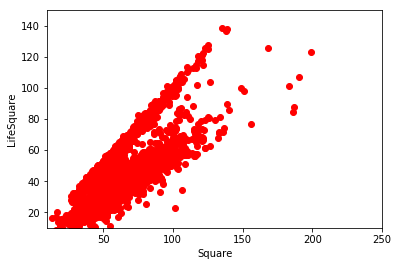

In [14]:
plt.plot(
    data['Square'],
    data['LifeSquare'],
    'ro'
)
plt.xlabel('Square')
plt.ylabel('LifeSquare')
plt.ylim(10,150)
plt.xlim(10,250)

Видно, что зависимость линейна. Предлагаю признак `LifeSquare` также не включать в итоговый датасет

Но для дестов давайте заполним средними значениями

In [15]:
lifeSquare_mean = data.LifeSquare.mean()
data['LifeSquare'].fillna(lifeSquare_mean, inplace=True)

#### Оценим признак `Square`

In [16]:
data['Square'].describe()

count    10000.000000
mean        56.230613
std         21.056022
min          1.136859
25%         41.751942
50%         52.482304
75%         65.889256
max        641.065193
Name: Square, dtype: float64

In [17]:
bad_square = data[data.Square < 10]
bad_square.shape[0]

23

А давайте их выкинем :)

In [18]:
data.drop(bad_square.index, inplace=True)

#### Оценим признак `HouseYear`

In [19]:
data['HouseYear'].value_counts()

1977.0        2640
2017.0         308
2016.0         303
2015.0         298
2014.0         208
1970.0         194
1969.0         189
1972.0         178
1971.0         177
2018.0         175
1974.0         169
1968.0         162
1965.0         161
1963.0         158
1976.0         155
1973.0         150
1975.0         150
1964.0         150
1967.0         146
1966.0         140
1978.0         129
1962.0         125
1960.0         121
1961.0         113
1982.0         110
1981.0         108
1979.0         107
1980.0         107
2005.0         102
1983.0         101
              ... 
1952.0          10
1953.0          10
1950.0           7
1935.0           7
1931.0           7
1939.0           6
1933.0           5
1918.0           5
1937.0           5
1940.0           4
1951.0           4
1934.0           4
1938.0           4
1942.0           3
1919.0           3
1930.0           3
1917.0           3
1936.0           3
1941.0           2
1932.0           2
1912.0           2
1929.0      

Видим явно выпадающие значения [4968, 20052011]

Заменим 4968 на 1968, 20052011 на 2008

In [20]:
data.loc[data.HouseYear == 4968, 'HouseYear'] = 1968
data.loc[data.HouseYear == 20052011, 'HouseYear'] = 2008

Ради интереса, построим гистограмму

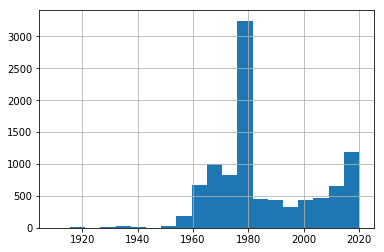

In [21]:
data['HouseYear'].hist(bins=20);

Примечательно - большинство квартир в домах построенных на рубеже конца 1970х - начала 1980х

#### Оценим признак `DistrictId`
Начнем с гистограммы

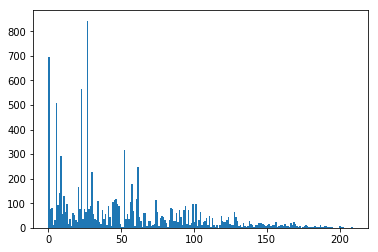

In [22]:
plt.hist(
    data['DistrictId'],
    bins=data['DistrictId'].nunique()
);

Это ничего не дало. Попробуем взять среднюю цену за квадратный метр по району

In [23]:
if not isfile('price_per_square_by_District.pickle'):
    data['price_per_square'] = data.Price / data.Square
    price_per_square_by_District = data.groupby(['DistrictId'])['price_per_square']\
    .mean().reset_index().rename(columns={'price_per_square': 'District_square_price'})
    
    pickle.dump(price_per_square_by_District, open('price_per_square_by_District.pickle', 'wb'))

In [24]:
price_per_square_by_District = pickle.load(open('price_per_square_by_District.pickle', 'rb'))

Доавим признак `District_square_price` к датасету

In [25]:
def add_distr_sq_price(df,price_per_square_by_District):
    # Среднее значение цена по всем районам
    dqp_mean = price_per_square_by_District['District_square_price'].mean()
    
    df=pd.merge(df,price_per_square_by_District,on='DistrictId',how='left')
    df['District_square_price'] = df['District_square_price'].fillna(dqp_mean)
    return df.drop(['DistrictId'], axis=1)

In [26]:
data = add_distr_sq_price(data, price_per_square_by_District)

In [27]:
data.head(3)

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,District_square_price
0,14038.0,2.0,47.981561,29.442751,6.0,7.0,9.0,1969.0,0.089040,B,B,33.0,7976.0,5.0,NaN,0.0,11.0,B,184966.930730,4384.628620
1,15053.0,3.0,65.683640,40.049543,8.0,7.0,9.0,1978.0,0.000070,B,B,46.0,10309.0,1.0,240.0,1.0,16.0,B,300009.450063,4293.480295
2,4765.0,2.0,44.947953,29.197612,0.0,8.0,12.0,1968.0,0.049637,B,B,34.0,7759.0,0.0,229.0,1.0,3.0,B,220925.908524,4835.401165


#### Оценим признаки `Floor` `HouseFloor`
Очистим выпадающие записи

In [28]:
floor_data = data[['Floor','HouseFloor']]
floor_data['HouseFloor'].value_counts()

17.0     2328
9.0      1388
12.0     1074
5.0      1031
14.0      625
16.0      575
1.0       492
25.0      373
22.0      341
0.0       265
24.0      176
8.0       141
10.0      135
4.0       133
3.0       125
15.0      122
19.0      107
20.0      105
18.0       89
7.0        59
6.0        58
2.0        47
23.0       40
21.0       33
11.0       28
13.0       27
30.0       21
40.0        7
27.0        6
37.0        4
32.0        4
28.0        3
48.0        2
99.0        2
39.0        2
117.0       1
29.0        1
31.0        1
38.0        1
44.0        1
36.0        1
26.0        1
45.0        1
47.0        1
Name: HouseFloor, dtype: int64

Давайте посмотрим на дома выше 30 этажей

In [29]:
def create_first_last_floor_columns(data):
    data['is_first_floor'] = (data.Floor == 1).astype(int)
    data['is_last_floor'] = (data.Floor >= data.HouseFloor).astype(int)
    return data

In [30]:
data = create_first_last_floor_columns(data)

#### KitchenSquare
25% данных о размерах кухни составляют 1, что не похоже на правду. 
Если это так, то данным признаком следует пренебречь, так как он крайне неточен

Для начала, построим гистограмму распределения квартир по площадям кухни

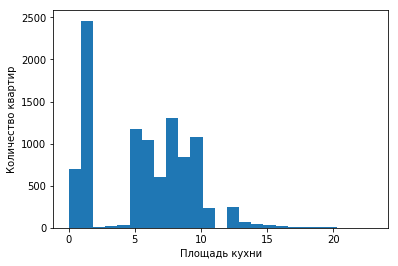

In [6]:
plt.hist(
    data['KitchenSquare'].loc[data.KitchenSquare < 25], 
    bins=25
)

plt.xlabel('Площадь кухни')
plt.ylabel('Количество квартир')
plt.show();

Давайте вычислим среднюю площадь квартиры, имеющую кухню площадью 1, а также общий процент таких квартир среди всей выборки

In [7]:
square_with_tiny_kitchen = data.loc[data.KitchenSquare <= 1]['Square'].loc[data.Square < 100]

In [8]:
square_with_tiny_kitchen.mean(), square_with_tiny_kitchen.count() / data['Square'].count()

(57.808910788199775, 0.3045)

Выходит, что 30% квартир имеют площадь кухни 1 и менее, при том что средняя площать среди них 57. Можно было бы объяснить отсутсвие кухонь в случае если объект является общежитием или апартаментами, но не с такой средней площадью. Из этого можно заключить что признак `KitchenSquare` невалиден и должен быть исключен из выборки.

И тем не менее, его надо как-то обрабатывать.

#### Healthcare_1
48% записей не имеют значения в признаке  `Healthcare_1`. 
Давайте развернем датасет - возьмем `Healthcare_1` в качестве целевого признака и построим модель для вычисления пустых значений

In [31]:
health1 = pd.get_dummies(data)
health1_train = health1[health1.Healthcare_1.notnull()].set_index('Id')
health1_test = health1[health1.Healthcare_1.isna()].drop(['Healthcare_1'], axis=1).set_index('Id')

In [32]:
def split_data(ds,target,test_size=0.25, random_state=42):
    """Разбивает датасет на тренировочные и проверочные, выделяя целевой признак"""
    X_train, X_test, y_train, y_test = train_test_split(
        ds.drop([target], axis=1), 
        ds[target], 
        test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [33]:
def get_model_r2(X_train, y_train, X_test, y_test, model):
    """Запускает целевую модель и выдает среднеквадратичное отклонение r2"""
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

In [34]:
if not isfile('Healthcare1.model'):
    # Разобьем датасет
    X_train, X_test, y_train, y_test = split_data(health1_train, 'Healthcare_1')

    # Используем GridSearchCV для нахождения оптимального дерева решений
    decision_tree = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                       param_grid=[{'max_depth': np.arange(2,40)}],
                       scoring='r2',
                       n_jobs=-1,
                       cv=5)

    decision_tree.fit(X_train, y_train);
    y_pred = decision_tree.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)
    
    print(f'Оптимальная глубина дерева: {decision_tree.best_params_["max_depth"]}')
    print(f'train r2: {decision_tree.best_score_:.4f}')
    print(f'test  r2: {test_r2:.4f}')
          
    pickle.dump(decision_tree, open('Healthcare1.model', 'wb'))

_Странная и непохожая на правду штоковина. Но различные методы дают схожий результат._
Заполним пустые поля признака `Healthcare_1` изначального датасета 

In [35]:
decision_tree = pickle.load(open('Healthcare1.model', 'rb'))
health1_test['Healthcare_1'] = decision_tree.predict(health1_test)

In [36]:
health1_predicted = health1_test['Healthcare_1'].reset_index()

In [37]:
data = pd.merge(data, health1_predicted, on='Id', how='inner')\
    .rename(columns={"Healthcare_1_y": "Healthcare_1"})\
    .drop(['Healthcare_1_x'], axis=1)

### Обучение моделей и их применение

#### Разбиение на тренировочные и тестовые

In [38]:
#data['Helthcare_2'] = data['Helthcare_2'].astype(object)

In [39]:
# ds = pd.get_dummies(data).drop(['Healthcare_1'], axis=1).set_index('Id')
ds = pd.get_dummies(data).set_index('Id')

In [40]:
X_train, X_test, y_train, y_test = split_data(ds, 'Price')

Стандартизируем значения:

In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.keys())
X_test_scaled = pd.DataFrame(
    scaler.fit_transform(X_test),
    columns=X_test.keys())

#### Линейная регрессия

In [42]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
get_model_r2(X_train_scaled, y_train, X_test_scaled, y_test, lr)

0.6864240513462907

In [43]:
# X_train_scaled = X_train
# X_test_scaled = X_test

In [44]:
xgb = XGBRegressor(colsample_bytree=0.5, gamma=0.0, 
                             learning_rate=0.005, max_depth=7, 
                             min_child_weight=0.5, n_estimators=5800,
                             reg_alpha=0.9, reg_lambda=0.99,
                             subsample=0.99,seed=42, silent=1,
                             random_state=42)

In [45]:
# ds = pd.get_dummies(data).drop(['Healthcare_1'], axis=1).set_index('Id')
# get_model_r2(X_train, y_train, X_test, y_test, xgb)
# 0.7548214320215614

In [46]:
# ds = pd.get_dummies(data).set_index('Id')
# get_model_r2(X_train, y_train, X_test, y_test, xgb)
# 0.7556017998096649

In [47]:
get_model_r2(X_train, y_train, X_test, y_test, xgb)

0.7556017998096649

#### Примение T-SNE
Попробуем перебрать параметр `learning_rates` чтобы найти идеальные условия для кластеризации

In [46]:
def train_tsne(lr):
    tsne = TSNE(n_components=2, learning_rate=lr, random_state=42)
    return tsne.fit_transform(X_train_scaled)

def get_good_tsne():
    learning_rates = [10, 50, 100, 150, 300, 500, 800, 1000]
    tsne_list = dict()
    with Pool() as p:  
        tsne_list = p.map(train_tsne, learning_rates)
    return dict(zip(learning_rates, tsne_list))

In [47]:
tsne_dict = get_good_tsne()

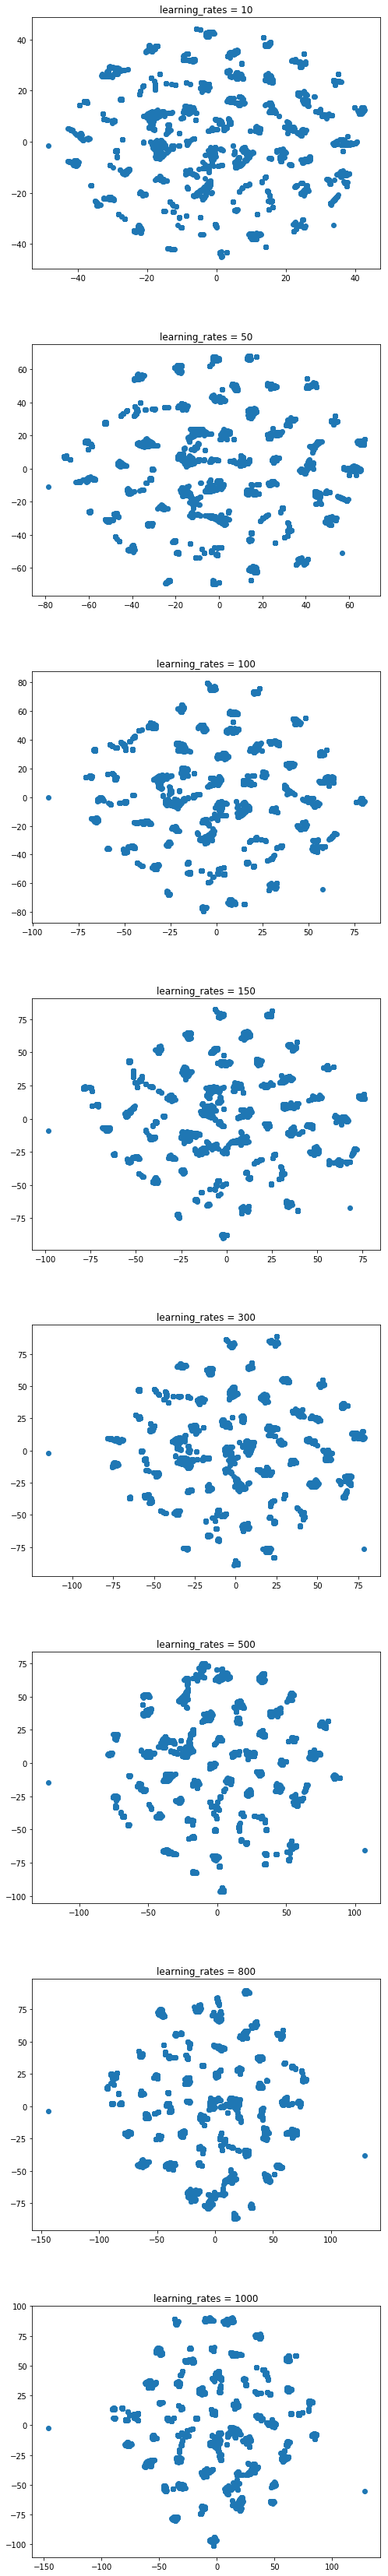

In [48]:
fig, ax = plt.subplots(len(tsne_dict),1)
fig.set_figwidth(8)
fig.set_figheight(60)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

i = 0
for lr, tsne_array in tsne_dict.items():
    ax[i].scatter(tsne_array[:, 0], tsne_array[:, 1])
    ax[i].set_title(f'learning_rates = {lr}')
    i += 1

По полученным графиком я не вижу явной возможности для кластеризации, так что исключим подобные алгоритмы.

Но давайте попробуем разбить на 3 кластера:

In [49]:
from sklearn.cluster import KMeans

In [50]:
kmeans = KMeans(n_clusters=3)
labels_train = kmeans.fit_predict(X_train_scaled)
pd.value_counts(labels_train)

0    1939
2    1477
1     409
dtype: int64

In [51]:
labels_train = kmeans.predict(X_train_scaled)

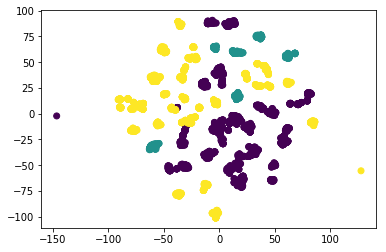

In [52]:
plt.scatter(
    tsne_dict[1000][:, 0],
    tsne_dict[1000][:, 1],
    c=labels_train
);

Так себе разбиение на кластеры, если честно

#### PCA (Метод главных компонент)
Попробуем выявить наиболее значимые признаки

In [197]:
print("Оценка линейной регрессии при разном количестве взятых признаков:")
for n in range(1,X_train.shape[1] + 1):
    pca = PCA(n_components=n, random_state=42)
    X_train_mc = pca.fit_transform(X_train_scaled)
    X_test_mc = pca.transform(X_test_scaled)
    lr = LinearRegression()
    r2 = get_model_r2(X_train_mc, y_train, X_test_mc, y_test, lr)
    
    print(f'при n = {n}, \t r2 = {r2:.4f},\tacc = {np.sum(pca.explained_variance_ratio_[:n])}')

Оценка линейной регрессии при разном количестве взятых признаков:
при n = 1, 	 r2 = 0.1774,	acc = 0.23111763929357984
при n = 2, 	 r2 = 0.2462,	acc = 0.32024577250534714
при n = 3, 	 r2 = 0.3438,	acc = 0.40570681297297284
при n = 4, 	 r2 = 0.5728,	acc = 0.48195643907292585
при n = 5, 	 r2 = 0.5874,	acc = 0.5488455946207731
при n = 6, 	 r2 = 0.5891,	acc = 0.6067773551591893
при n = 7, 	 r2 = 0.5919,	acc = 0.6615383898540208
при n = 8, 	 r2 = 0.5974,	acc = 0.7099048653658862
при n = 9, 	 r2 = 0.5981,	acc = 0.7541733515644412
при n = 10, 	 r2 = 0.6067,	acc = 0.7965622348579926
при n = 11, 	 r2 = 0.6067,	acc = 0.8374697732112005
при n = 12, 	 r2 = 0.6067,	acc = 0.8717932661760995
при n = 13, 	 r2 = 0.6085,	acc = 0.9050900981871918
при n = 14, 	 r2 = 0.6077,	acc = 0.9320251238810958
при n = 15, 	 r2 = 0.6076,	acc = 0.9513325674810009
при n = 16, 	 r2 = 0.6522,	acc = 0.9662831040976891
при n = 17, 	 r2 = 0.6544,	acc = 0.977368782184006
при n = 18, 	 r2 = 0.6544,	acc = 0.9873312287376723
при 

Мы видим что лучший результат достигается при $n = 19$

In [198]:
pca = PCA(n_components=19, random_state=42)

X_train_mc = pca.fit_transform(X_train_scaled)

X_test_mc = pca.transform(X_test_scaled)

get_model_r2(X_train_mc, y_train, X_test_mc, y_test, lr)

0.672546719760197

#### Дерево решений

In [199]:
decision_tree = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                   param_grid=[{'max_depth': np.arange(2,40)}],
                   scoring='r2',
                   n_jobs=-1,
                   cv=5)

In [200]:
decision_tree.fit(X_train_mc, y_train);

In [201]:
print(f'best max_depth: {decision_tree.best_params_["max_depth"]}, \tbest r2:{decision_tree.best_score_}')

best max_depth: 5, 	best r2:0.6601146607476543


In [202]:
y_pred=decision_tree.predict(X_test_mc)
r2_score(y_test, y_pred)

0.487934530607555

In [203]:
def do_tree(max_depth):
    model = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    return get_model_r2(X_train_mc, y_train, X_test_mc, y_test, model)
    
def best_tree_score():
    max_depths = np.arange(2,40)
    with Pool() as p:  
        tree_score_list = p.map(do_tree, max_depths)
    return dict(zip(max_depths, tree_score_list))

In [204]:
tree_dict = best_tree_score()

In [205]:
print("Оценка дерева решений с переменной глубиной ")
for depth, r2 in tree_dict.items():
    print(f'max_depth: {depth} \t r2: {r2:.4f}')

Оценка дерева решений с переменной глубиной 
max_depth: 2 	 r2: 0.4201
max_depth: 3 	 r2: 0.4703
max_depth: 4 	 r2: 0.4462
max_depth: 5 	 r2: 0.4879
max_depth: 6 	 r2: 0.5003
max_depth: 7 	 r2: 0.4466
max_depth: 8 	 r2: 0.3866
max_depth: 9 	 r2: 0.4402
max_depth: 10 	 r2: 0.3449
max_depth: 11 	 r2: 0.3572
max_depth: 12 	 r2: 0.3681
max_depth: 13 	 r2: 0.3125
max_depth: 14 	 r2: 0.2863
max_depth: 15 	 r2: 0.2922
max_depth: 16 	 r2: 0.2870
max_depth: 17 	 r2: 0.2337
max_depth: 18 	 r2: 0.3253
max_depth: 19 	 r2: 0.2894
max_depth: 20 	 r2: 0.2419
max_depth: 21 	 r2: 0.2826
max_depth: 22 	 r2: 0.2599
max_depth: 23 	 r2: 0.2925
max_depth: 24 	 r2: 0.2754
max_depth: 25 	 r2: 0.2397
max_depth: 26 	 r2: 0.2559
max_depth: 27 	 r2: 0.2813
max_depth: 28 	 r2: 0.2695
max_depth: 29 	 r2: 0.2671
max_depth: 30 	 r2: 0.2755
max_depth: 31 	 r2: 0.3044
max_depth: 32 	 r2: 0.3026
max_depth: 33 	 r2: 0.2776
max_depth: 34 	 r2: 0.2695
max_depth: 35 	 r2: 0.2823
max_depth: 36 	 r2: 0.2830
max_depth: 37 	 r2

In [62]:
!telegram-send 'Проверяй!'

Config not found
Please run: telegram-send --configure


При вычислении регресси деревом решений глубины 6 мы получаем точность $r2 = 0.54$

#### Случайный лес

In [63]:
decision_tree = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                   param_grid=[{'max_depth': np.arange(2,40)}],
                   scoring='r2',
                   n_jobs=-1,
                   cv=5)

In [64]:
def do_forest(max_depth):
    model = RandomForestRegressor(n_estimators=1000, max_depth=max_depth, random_state=42)
    return get_model_r2(X_train_mc, y_train, X_test_mc, y_test, model)
    
def best_forest_score():
    max_depths = np.arange(15,31)
    with Pool() as p:  
        forest_score_list = p.map(do_forest, max_depths)
    return dict(zip(max_depths, forest_score_list))

In [65]:
forest_dict = best_forest_score()

In [66]:
!telegram-send "Я сделялъ"

Config not found
Please run: telegram-send --configure


In [67]:
print("Оценка случайных деревьев с переменной глубиной ")
for depth, r2 in forest_dict.items():
    print(f'max_depth: {depth} \t r2: {r2:.4f}')

Оценка случайных деревьев с переменной глубиной 
max_depth: 15 	 r2: 0.7093
max_depth: 16 	 r2: 0.7094
max_depth: 17 	 r2: 0.7089
max_depth: 18 	 r2: 0.7089
max_depth: 19 	 r2: 0.7089
max_depth: 20 	 r2: 0.7095
max_depth: 21 	 r2: 0.7086
max_depth: 22 	 r2: 0.7094
max_depth: 23 	 r2: 0.7087
max_depth: 24 	 r2: 0.7085
max_depth: 25 	 r2: 0.7086
max_depth: 26 	 r2: 0.7093
max_depth: 27 	 r2: 0.7089
max_depth: 28 	 r2: 0.7089
max_depth: 29 	 r2: 0.7089
max_depth: 30 	 r2: 0.7092


При вычислении регрессии случайным лесом глубиной 23 мы получаем точность $r2 = 0.7072$

#### Расширенный случайный лес
будем использовать также `GredSearchCV`

In [68]:
parametrs = [{'n_estimators': [150,200,250,500,750,1000],
              'max_features': ["auto", "sqrt", "log2"],
              'max_depth': np.arange(10,25)}]

In [206]:
clf = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                   param_grid=parametrs,
                   scoring='r2',
                   n_jobs=-1,
                   cv=5)

In [207]:
clf.fit(X_train_mc, y_train)

KeyboardInterrupt: 

In [71]:
clf.best_params_, clf.best_score_

({'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 200},
 0.790034250633083)

Наилучшие парамедры для случайного леса:

'max_depth': 21, 'max_features': 'sqrt', 'n_estimators': 750

r2 = 0.719

In [84]:
y_pred = clf.predict(X_test_mc)
test_r2 = r2_score(y_test, y_pred)
test_r2

0.7125869949316297

#### L1, L2 регуляризация

In [80]:
test = pd.read_csv(test_path)

In [81]:
data.Helthcare_2.value_counts()

0.0    2928
1.0    1257
3.0     320
5.0     175
2.0     102
Name: Helthcare_2, dtype: int64